## CAMELs sims

Just check we can load and plot the 2D CAMELs fields from IllustrisTNG

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from kymatio.numpy import Scattering2D
from sn_camels.models.models_factory import baseModelFactory, topModelFactory
from sn_camels.models.sn_hybrid_models import sn_HybridModel
import torch

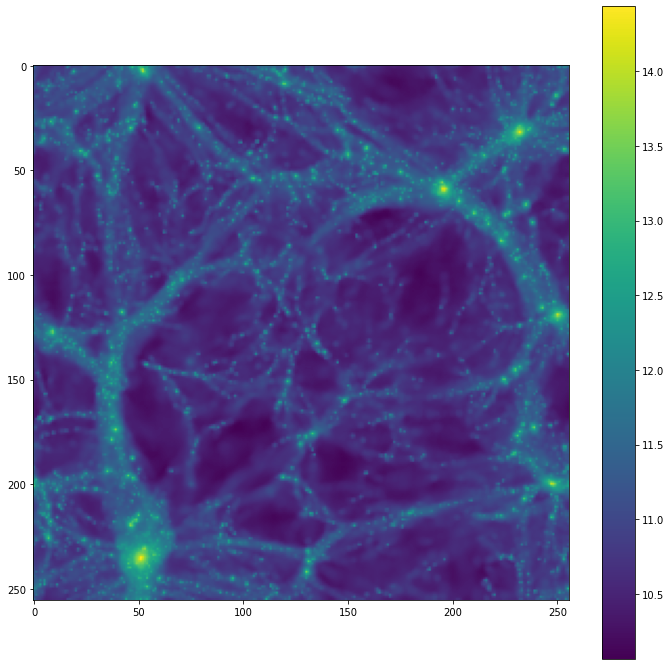

In [2]:
data_string=os.environ['CAMELS_PATH']+"/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy"
param_string=os.environ['CAMELS_PATH']+"/params_IllustrisTNG.txt"

## Import maps and parameters
maps = np.load(data_string)
params=np.loadtxt(param_string)

maps=maps[:10]

##Pick a field, any field
field_index=np.random.randint(len(maps))

plt.figure(figsize=(12,12))
plt.imshow(np.log10(maps[field_index]))
plt.colorbar()

/home/chris/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


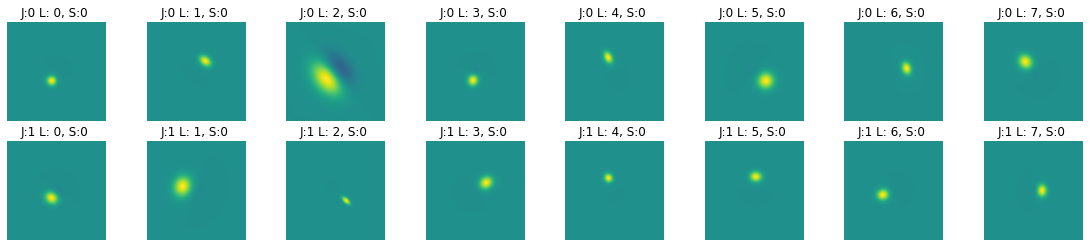

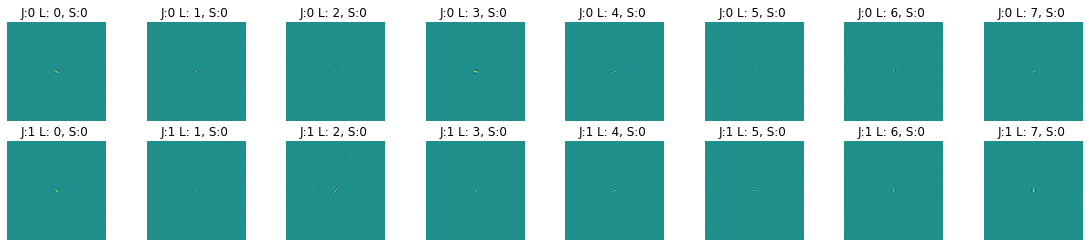

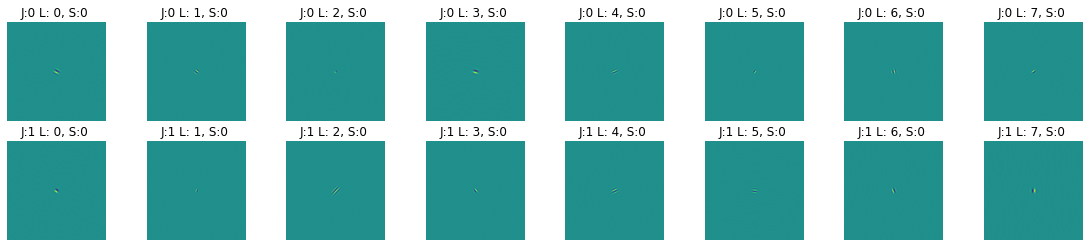

In [3]:
## Make one of our sn_camels models

scatteringBase = baseModelFactory( #creat scattering base model
    architecture='scattering',
    J=2,
    N=256,
    M=256,
    second_order=True,
    initialization="Random",
    seed=123,
    learnable=False,
    lr_orientation=0.1,
    lr_scattering=0.1,
    filter_video=False,
    device="cpu",
    use_cuda=False
)

top = topModelFactory( #create cnn, mlp, linearlayer, or other
    base=scatteringBase,
    architecture="linear_layer",
    num_classes=12, 
    width=8, 
    use_cuda=False
)

hybridModel = sn_HybridModel(scatteringBase=scatteringBase, top=top, use_cuda=False) #creat hybrid model

In [4]:
scattering=Scattering2D(J=1,shape=(256,256),max_order=1)
scattering2=Scattering2D(J=2,shape=(256,256),max_order=1)
scattering3=Scattering2D(J=3,shape=(256,256),max_order=1)

In [5]:
scattered=scattering(maps[field_index])
scattered2=scattering2(maps[field_index])
scattered3=scattering3(maps[field_index])

In [6]:
scattering2.phi[0].shape

(264, 264)

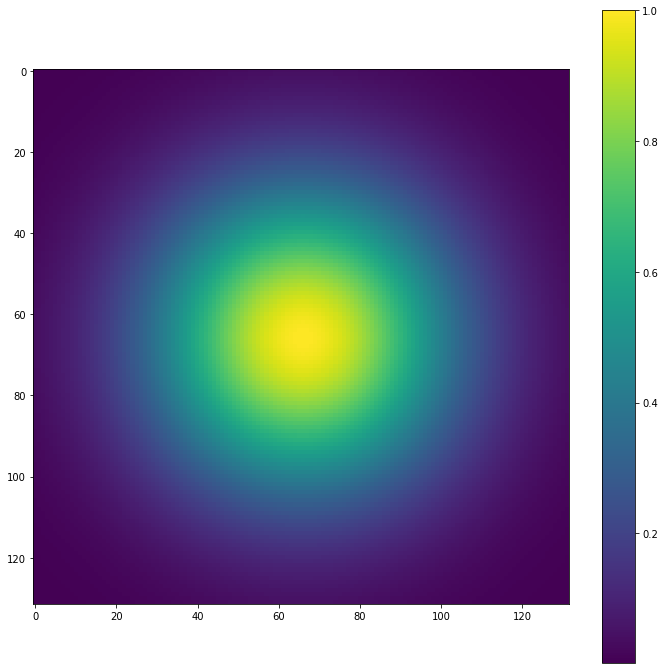

In [7]:
plt.figure(figsize=(12,12))
plt.imshow(np.fft.fftshift(scattering2.phi[1]))
plt.colorbar()

In [8]:
## 2nd order scattering
scattering_order2 = Scattering2D(J=2, shape=(256, 256),max_order=2)
scattered_order2=scattering_order2(maps[field_index])

In [9]:
def scattering2d(x, pad, unpad, backend, J, L, phi, psi, max_order,
        out_type='array'):
    """ Function to take an input image and perform a series of scattering
    convolutions."""
    subsample_fourier = backend.subsample_fourier
    modulus = backend.modulus
    fft = backend.fft
    cdgmm = backend.cdgmm
    concatenate = backend.concatenate

    # Define lists for output.
    out_S_0, out_S_1, out_S_2 = [], [], []

    U_r = pad(x)

    U_0_c = fft(U_r, 'C2C')

    # First low pass filter
    U_1_c = cdgmm(U_0_c, phi[0])
    U_1_c = subsample_fourier(U_1_c, k=2 ** J)

    S_0 = fft(U_1_c, 'C2R', inverse=True)
    S_0 = unpad(S_0)

    out_S_0.append({'coef': S_0,
                    'j': (),
                    'theta': ()})

    for n1 in range(len(psi)):
        j1 = psi[n1]['j']
        theta1 = psi[n1]['theta']

        U_1_c = cdgmm(U_0_c, psi[n1][0])
        if j1 > 0:
            U_1_c = subsample_fourier(U_1_c, k=2 ** j1)
        U_1_c = fft(U_1_c, 'C2C', inverse=True)
        U_1_c = modulus(U_1_c)
        U_1_c = fft(U_1_c, 'C2C')

        # Second low pass filter
        S_1_c = cdgmm(U_1_c, phi[j1])
        S_1_c = subsample_fourier(S_1_c, k=2 ** (J - j1))

        S_1_r = fft(S_1_c, 'C2R', inverse=True)
        S_1_r = unpad(S_1_r)

        out_S_1.append({'coef': S_1_r,
                        'j': (j1,),
                        'theta': (theta1,)})

        if max_order < 2:
            continue
        for n2 in range(len(psi)):
            j2 = psi[n2]['j']
            theta2 = psi[n2]['theta']

            if j2 <= j1:
                continue

            U_2_c = cdgmm(U_1_c, psi[n2][j1])
            U_2_c = subsample_fourier(U_2_c, k=2 ** (j2 - j1))
            U_2_c = fft(U_2_c, 'C2C', inverse=True)
            U_2_c = modulus(U_2_c)
            U_2_c = fft(U_2_c, 'C2C')

            # Third low pass filter
            S_2_c = cdgmm(U_2_c, phi[j2])
            S_2_c = subsample_fourier(S_2_c, k=2 ** (J - j2))

            S_2_r = fft(S_2_c, 'C2R', inverse=True)
            S_2_r = unpad(S_2_r)

            out_S_2.append({'coef': S_2_r,
                            'j': (j1, j2),
                            'theta': (theta1, theta2)})

    out_S = []
    out_S.extend(out_S_0)
    out_S.extend(out_S_1)
    out_S.extend(out_S_2)

    if out_type == 'array':
        out_S = concatenate([x['coef'] for x in out_S])

    return out_S

In [15]:
out=scattering.backend.subsample_fourier(maps,2)
out2=scattering.backend.subsample_fourier(out,2)

In [17]:
out2.shape

(10, 64, 64)

In [12]:
maps.shape

(10, 256, 256)

In [ ]:
scattered_model=scatteringBase.scattering(torch.from_numpy(maps[field_index]))

In [ ]:
scattered_model[70].shape

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(np.log10(scattered_model[65]))
plt.colorbar()
plt.show()

In [ ]:
scattering2.backend

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(np.log10(scattered[0]))
plt.show()

In [ ]:
scatteringBase.n_coefficients

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(np.log10(scattered2[3]))
plt.show()

In [ ]:
len(scattered_order2)

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(np.log10(scattered_order2[3]))
plt.show()

In [ ]:
np.shape(scattered_order2)

In [ ]:
scattering_order2.psi

## Scattering and convolutions

Dig a little bit into the mechanics here. So after setting the input dimensions, we next create filters, using `filter_bank`

In [ ]:
len(scattering2.psi)

In [ ]:
scattering2.psi[2][0].shape

In [ ]:
plt.imshow(scattering3.psi[17][0])

In [ ]:
plt.imshow(scattering3.psi[16][0])
plt.colorbar()

In [ ]:
scattering.M

In [ ]:
scattering.psi[6][0]

In [ ]:
plt.plot(scattering3.psi[16][0][150])

In [ ]:
scat